# TPG Examples
This document shows how to use the PyTPG API. We make use of OpenAI Gym to run examples, and we assume you already have PyTPG installed, see the readme for installation instructions for PyTPG.

## General Setup

In [1]:
from __future__ import division
# imports to run OpenAI Gym in Jupyter
import gym
import matplotlib.pyplot as plt
from IPython import display

# how to render in Jupyter: 
# https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server
# https://www.youtube.com/watch?v=O84KgRt6AJI
def show_state(env, step=0, name='', info=''):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (name, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
# transforms the state into what the tpg agent can use.
# From 3D to 1D, taking only red data (from rgb array)
def getState(state):
    state2 = []
    for x in state:
        for y in x:
            state2.append(y[0])
            
    return state2

In [2]:
env = gym.make('Assault-v0') # make the environment

In [3]:
print(env.action_space) # learn size of action space

Discrete(7)


In [4]:
# import to do training
from tpg.tpg_trainer import TpgTrainer
# import to run an agent (always needed)
from tpg.tpg_agent import TpgAgent

## Generational Selection

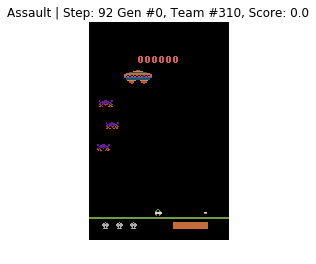

In [ ]:
%matplotlib inline
import time # for tracking time

tStart = time.time()

# first create an instance of the TpgTrainer
# this creates the whole population and everything
trainer = TpgTrainer(actions=range(7), teamPopSizeInit=50)

curScores = [] # hold scores in a generation
summaryScores = [] # record score summaries for each gen (min, max, avg)

# 5 generations isn't much (not even close), but some improvements
# should be seen.
for gen in range(5): # generation loop
    curScores.clear() # new list per gen
    
    while True: # loop to go through agents
        teamNum = trainer.remainingAgents()
        agent = trainer.getNextAgent()
        if agent is None:
            break # no more agents, so proceed to next gen
        
        state = env.reset() # get initial state and prep environment
        score = 0
        for i in range(200): # run episodes that last 200 frames
            show_state(env, i, 'Assault', 'Gen #' + str(gen) + 
                       ', Team #' + str(teamNum) +
                       ', Score: ' + str(score)) # render env
            
            act = agent.act(getState(state)) # get action from agent
            
            # feedback from env
            state, reward, isDone, debug = env.step(act)
            score += reward # accumulate reward in score
            if isDone:
                break # end early if losing state
                
        agent.reward(score) # must reward agent
        curScores.append(score) # store score
            
    # at end of generation, make summary of scores
    scoreRec.append((min(curScores), max(curScores),
                    sum(curScores)/len(curScores))) # min, max, avg
    
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results: ' + str(scoreRec))

# Generational Selection with Multiprocessing

In [1]:
from multiprocessing import Pool

trainer = TpgTrainer(actions=range(7)) # reset trainer

def runAgent(agent):
    

p = Pool(5)
print(p.map(runAgent, trainer.getAllAgents()))

[1, 4, 9, 16, 25, 36]


In [ ]:
%matplotlib inline
import time # for tracking time

tStart = time.time()

# first create an instance of the TpgTrainer
# this creates the whole population and everything
trainer = TpgTrainer(actions=range(7))

curScores = [] # hold scores in a generation
summaryScores = [] # record score summaries for each gen (min, max, avg)

# 5 generations isn't much (not even close), but some improvements
# should be seen.
for gen in range(5): # generation loop
    curScores.clear() # new list per gen
    
    while True: # loop to go through agents
        teamNum = trainer.remainingAgents()
        agent = trainer.getNextAgent()
        if agent is None:
            break # no more agents, so proceed to next gen
        
        state = env.reset() # get initial state and prep environment
        score = 0
        for i in range(200): # run episodes that last 200 frames
            show_state(env, i, 'Assault', 'Gen #' + str(gen) + 
                       ', Team #' + str(teamNum) +
                       ', Score: ' + str(score)) # render env
            
            act = agent.act(getState(state)) # get action from agent
            
            # feedback from env
            state, reward, isDone, debug = env.step(act)
            score += reward # accumulate reward in score
            if isDone:
                break # end early if losing state
                
        agent.reward(score) # must reward agent
        curScores.append(score) # store score
            
    # at end of generation, make summary of scores
    scoreRec.append((min(curScores), max(curScores),
                    sum(curScores)/len(curScores))) # min, max, avg
    
print('Time Taken (Seconds): ' str(time.time() - tStart))
print('Results: ' + str(scoreRec))

## Tournament Selection